In [12]:
import numpy as np
import pandas as pd #data wrangeling
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
import os #for setting the working drectory

In [17]:
#Problem: Somehow i cannot install the ETSModel because of the following error:
#ModuleNotFoundError: No module named 'statsmodels.tsa.exponential_smoothing.ets'
#from statsmodels.tsa.exponential_smoothing.ets import ETSModel

ModuleNotFoundError: No module named 'statsmodels.tsa.exponential_smoothing.ets'

In [19]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [122]:
#Importing evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [20]:
#setting working directory
os.chdir("C:/Users/mah/Desktop/M5_Wallmart_Challenge")
os.getcwd()

'C:\\Users\\mah\\Desktop\\M5_Wallmart_Challenge'

In [21]:
#importing data
sales_train_validation = pd.read_csv("sales_train_validation.csv") #Sales per Item
calendar = pd.read_csv("calendar.csv", parse_dates=['date']) #Calender Information
sell_prices = pd.read_csv("sell_prices.csv") #Prices per Item

#LL: the sales_train_validation data frame is very large, it couldent load because I didn't have enough memory.
#When I closed most of my tabs it worked.
#I also had problems in merging data sets, it either gave back that hte memory was insfficient or took long (over 30 min).
#Somehow it works better after restarting the computer
#Closing tabs doesn't have the same effect
#Further note that after restarting the computer and installing
#
#The parse_dates command makes python recognise the data variable in the sales and calendar data as dates
#Alternatively doing it manually after reading the data: (here the example for the calendar)
#calendar['date'] = pd.to_datetime(calendar['date'], format='%Y/%m/%d')

In [22]:
#inspection of sales amount data
sales_train_validation

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3


In [23]:
#inspection of price data
sell_prices

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


In [24]:
#inspecting calendar data
calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [25]:
#merging calendar and price data depent on the week, year and month
#Note: Price are only provided as weekly averages
calendar_sell_prices = pd.merge(sell_prices, calendar, on='wm_yr_wk')
calendar_sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price,date,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,CA_1,HOBBIES_1_001,11325,9.58,2013-07-13,Saturday,1,7,2013,d_897,NaN,NaN,NaN,NaN,0,1,0
1,CA_1,HOBBIES_1_001,11325,9.58,2013-07-14,Sunday,2,7,2013,d_898,NaN,NaN,NaN,NaN,0,0,1
2,CA_1,HOBBIES_1_001,11325,9.58,2013-07-15,Monday,3,7,2013,d_899,NaN,NaN,NaN,NaN,0,1,1
3,CA_1,HOBBIES_1_001,11325,9.58,2013-07-16,Tuesday,4,7,2013,d_900,NaN,NaN,NaN,NaN,0,0,0
4,CA_1,HOBBIES_1_001,11325,9.58,2013-07-17,Wednesday,5,7,2013,d_901,NaN,NaN,NaN,NaN,0,0,0


In [26]:
#reducing calendar and price data to store, item, price and day
#Note: minimum necessary to merge with the sales amount data + date variable
calendar_sell_prices_reduced = calendar_sell_prices.drop(
    ['wm_yr_wk','weekday','wday','month','year',
     'event_name_1','event_type_1', 'event_name_2', 
     'event_type_2','snap_CA','snap_TX','snap_WI'], axis=1)
calendar_sell_prices_reduced.head()

,store_id,item_id,sell_price,date,d
0,CA_1,HOBBIES_1_001,9.58,2013-07-13,d_897
1,CA_1,HOBBIES_1_001,9.58,2013-07-14,d_898
2,CA_1,HOBBIES_1_001,9.58,2013-07-15,d_899
3,CA_1,HOBBIES_1_001,9.58,2013-07-16,d_900
4,CA_1,HOBBIES_1_001,9.58,2013-07-17,d_901


In [27]:
#Changing the sales data so that the day and the sold units become columns
#Note helps to combine the data with the price data by store, item and day
sales_train_validation_pivot = sales_train_validation.melt(id_vars=["id","item_id","dept_id",
                                     "cat_id","store_id","state_id"], 
                                  var_name="d", 
                                  value_name="sold_units")

sales_train_validation_pivot.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold_units
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [28]:
#merging calendar and price data with the sales data by item, store and day
sales_prices = pd.merge(calendar_sell_prices_reduced,sales_train_validation_pivot, 
         on=['item_id','store_id','d'])
sales_prices.head()

,store_id,item_id,sell_price,date,d,id,dept_id,cat_id,state_id,sold_units
0,CA_1,HOBBIES_1_001,9.58,2013-07-13,d_897,HOBBIES_1_001_CA_1_validation,HOBBIES_1,HOBBIES,CA,0
1,CA_1,HOBBIES_1_001,9.58,2013-07-14,d_898,HOBBIES_1_001_CA_1_validation,HOBBIES_1,HOBBIES,CA,0
2,CA_1,HOBBIES_1_001,9.58,2013-07-15,d_899,HOBBIES_1_001_CA_1_validation,HOBBIES_1,HOBBIES,CA,0
3,CA_1,HOBBIES_1_001,9.58,2013-07-16,d_900,HOBBIES_1_001_CA_1_validation,HOBBIES_1,HOBBIES,CA,0
4,CA_1,HOBBIES_1_001,9.58,2013-07-17,d_901,HOBBIES_1_001_CA_1_validation,HOBBIES_1,HOBBIES,CA,0


In [29]:
#convert the price and sales variables into floats so that they can be multiplied
sales_prices[['sell_price', 'sold_units']] = sales_prices[['sell_price', 'sold_units']].astype(float)

In [30]:
#compute the revenue and store it into a new column
#Note: here we have the revenue per item, store and day
sales_prices['revenue'] = sales_prices['sell_price']*sales_prices['sold_units']

In [31]:
sales_prices

,store_id,item_id,sell_price,date,d,id,dept_id,cat_id,state_id,sold_units,revenue
0,CA_1,HOBBIES_1_001,9.58,2013-07-13,d_897,HOBBIES_1_001_CA_1_validation,HOBBIES_1,HOBBIES,CA,0.0,0.0
1,CA_1,HOBBIES_1_001,9.58,2013-07-14,d_898,HOBBIES_1_001_CA_1_validation,HOBBIES_1,HOBBIES,CA,0.0,0.0
2,CA_1,HOBBIES_1_001,9.58,2013-07-15,d_899,HOBBIES_1_001_CA_1_validation,HOBBIES_1,HOBBIES,CA,0.0,0.0
3,CA_1,HOBBIES_1_001,9.58,2013-07-16,d_900,HOBBIES_1_001_CA_1_validation,HOBBIES_1,HOBBIES,CA,0.0,0.0
4,CA_1,HOBBIES_1_001,9.58,2013-07-17,d_901,HOBBIES_1_001_CA_1_validation,HOBBIES_1,HOBBIES,CA,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
46027952,WI_3,FOODS_3_825,4.00,2011-02-28,d_31,FOODS_3_825_WI_3_validation,FOODS_3,FOODS,WI,1.0,4.0
46027953,WI_3,FOODS_3_825,4.00,2011-03-01,d_32,FOODS_3_825_WI_3_validation,FOODS_3,FOODS,WI,2.0,8.0
46027954,WI_3,FOODS_3_825,4.00,2011-03-02,d_33,FOODS_3_825_WI_3_validation,FOODS_3,FOODS,WI,2.0,8.0
46027955,WI_3,FOODS_3_825,4.00,2011-03-03,d_34,FOODS_3_825_WI_3_validation,FOODS_3,FOODS,WI,2.0,8.0


In [32]:
#Summarizing the daily revenue of the categroy FOODS for the store CA_1 per day
#Note: sorted by date
revenue_CA_1_FOODS_day = sales_prices.loc[(sales_prices['store_id'] == 'CA_1') & 
                 (sales_prices['cat_id'] == 'FOODS')].sort_values('date').groupby(['date']).sum().drop(['sell_price','sold_units'], axis=1)
revenue_CA_1_FOODS_day

#LL:
#When Grouping and summing, all variables fall out that are not grouped by or floats.
#Floats is important because only floats can be summed up.
#In This example:
#- don't need to drop 'item_id', 'dept_id','state_id'
#- but I do need to drop 'sell_price','sold_units' as they are floats
#Droping variables can be done before or after the grouping
#
#Further note that grouping results in only one result column, thus if i need the indexes of other columns,
#The other columns need to be rejoined by extracting them from the ungrouped data set
#
#Note: I need to sort the data by the date and also group it by the date, otherwise it is in the wrong order
#
#Therefore I first do the analysis only for the aggregated Food revenue in CA_1
#Later I will make a loop and do the model for all different store category combinations
#gets every possible value of a column command for the loop:
#sales_prices.store_id.unique()
#sales_prices.cat_id.unique()
#
#Note: Hanging Python commands after one another is done with a dote '.'

,revenue
date,
2011-01-29,7240.65
2011-01-30,6705.51
2011-01-31,4584.85
2011-02-01,4965.46
2011-02-02,4368.07
...,...
2016-04-20,6938.53
2016-04-21,6824.21
2016-04-22,8226.64


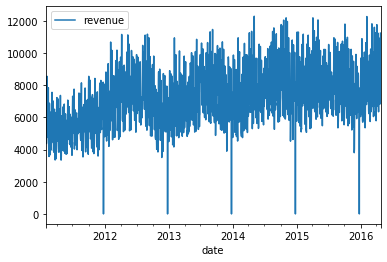

In [33]:
#Simpler plot der Ergebnisse
revenue_CA_1_FOODS_day.plot()
plt.show()

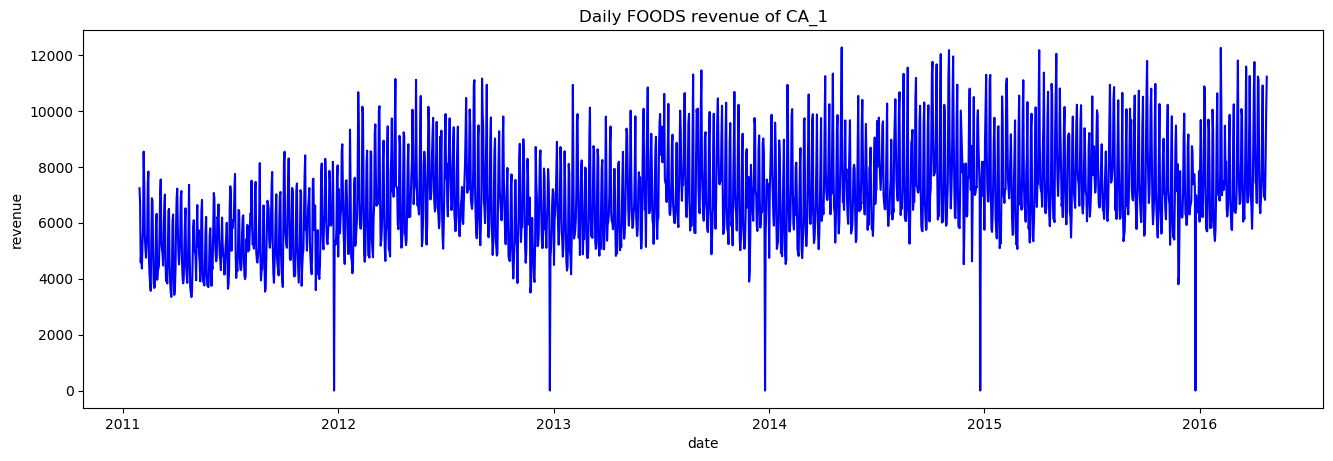

In [34]:
# Draw Plot
def plot_df(revenue_CA_1_FOODS_day, x, y, title="", xlabel='date', ylabel='revenue', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(revenue_CA_1_FOODS_day, 
        x=revenue_CA_1_FOODS_day.index, 
        y=revenue_CA_1_FOODS_day.revenue, 
        title='Daily FOODS revenue of CA_1')

#Function from: https://www.machinelearningplus.com/time-series/time-series-analysis-python/

In [35]:
from statsmodels.tsa.stattools import adfuller
# Augmented Dickey Fuller Test
result = adfuller(revenue_CA_1_FOODS_day.revenue.values, autolag='AIC', maxlag=365)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
    
#ADF test:
#H0: time series possesses a unit root and is non-stationary
#So, if the P-Value in ADF test is less than the significance level (0.05), you reject H0, thus the series is stationary
#Here the P-Value is smaller than 10% thus at least a a 10% significane level we can say that the series is stationary
#
#Note: I define the max. lag at 365 due to yearly seasonality
#Because of the higher max.lag than is standard in the algorithm the p-value dropped significantly from 0.42 --> 0.07
#which makes the rejection of a random walk stronger
#Doing the test with maxlag=0 results in a random walk, which makes sense as we didn't control for autoregressive characteristics

ADF Statistic: -2.7067204269343144
p-value: 0.07288254399707181
Critial Values:
   1%, -3.434584120148502
Critial Values:
   5%, -2.863410105779459
Critial Values:
   10%, -2.5677656145911203


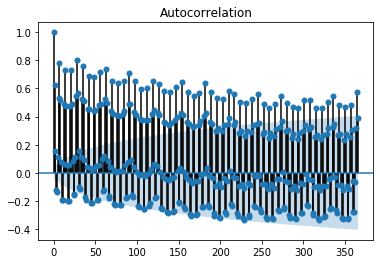

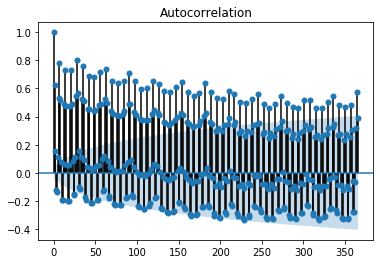

In [36]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(revenue_CA_1_FOODS_day.revenue, lags=365)

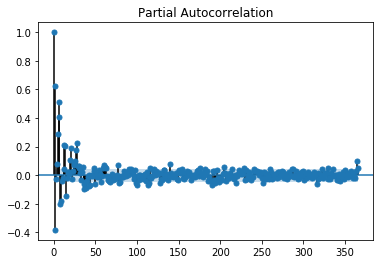

In [37]:
plot_pacf(revenue_CA_1_FOODS_day.revenue, lags=365, method='ywm')
plt.show()
#Note: I had to include the ywm method
#Tip from: https://stackoverflow.com/questions/51436580/linear-model-py1283-runtimewarning-invalid-value-encountered-in-sqrt-return-r
# I exclude the bias correction in the yule walker method

#Note: OLS Method with constant (similar results)
#plot_pacf(revenue_CA_1_FOODS_day.revenue, lags=365, method='ols')

In [38]:
#Taking out the christmas effect by assuming sales to be the mean of the sales the day before and after christmas
#Purpose: to eiminate distortions of christmas on the parameter estimates
#Alternative: Christmas dummy, but as sales rise over time one would need one dummy per christmas day

#Logic behind the Loop:
#for every row in the time series...
#if the time index (defined as time variable previously) day is equal to 25 and the monht to 12...
#Then set the revenue value of that row equal to the mean of the previous and next days revenues
for i in range(len(revenue_CA_1_FOODS_day)):
    if ((revenue_CA_1_FOODS_day.index.day[i] == 25) and (revenue_CA_1_FOODS_day.index.month[i] == 12)):
        revenue_CA_1_FOODS_day['revenue'][i] = (revenue_CA_1_FOODS_day['revenue'][i-1] + 
                                               revenue_CA_1_FOODS_day['revenue'][i+1])/2
        

In [105]:
#Define training and testing data set

#for dependent variables
revenue_CA_1_FOODS_day_to_train = revenue_CA_1_FOODS_day.iloc[:(len(revenue_CA_1_FOODS_day)-31)]
revenue_CA_1_FOODS_day_to_test = revenue_CA_1_FOODS_day.iloc[(len(revenue_CA_1_FOODS_day)-31):]

In [106]:
#Holt-Winter Exponential Smoothing Model
#Model includes weekly seasonality and a trend in na exponential smoothing manner
#Note: the expoential smoothing models are essentially state space models
#For more on the theory: Hyndman Chapter 7
#Documentation: https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html
#Tutorial from where I used the code: https://www.statsmodels.org/stable/examples/notebooks/generated/exponential_smoothing.html
fit1 = ExponentialSmoothing(revenue_CA_1_FOODS_day_to_train, seasonal_periods=7, freq='D', trend='add', seasonal='add').fit()
fit2 = ExponentialSmoothing(revenue_CA_1_FOODS_day_to_train, seasonal_periods=7, freq='D', trend='add', seasonal='mul').fit()
fit3 = ExponentialSmoothing(revenue_CA_1_FOODS_day_to_train, seasonal_periods=7, freq='D', trend='add', seasonal='add', damped=True).fit()
fit4 = ExponentialSmoothing(revenue_CA_1_FOODS_day_to_train, seasonal_periods=7, freq='D', trend='add', seasonal='mul', damped=True).fit()

C:\Users\mah\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\mah\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


In [144]:
#creating a results tabel for all parameters
#alpha: smoothing parameter for the level
#beta: smoothing parameter for the trend
#gamma: smoothing parameter for the seasonality
#phi: dampening factor
#l0: initial value for the level
#b0: initial value for the trend
results=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$\gamma$",r"$l_0$","$b_0$","SSE","AIC"])
results["Additive"]       = [fit1.params[p] for p in params] + [fit1.sse] + [fit1.aic]
results["Multiplicative"] = [fit2.params[p] for p in params] + [fit2.sse] + [fit2.aic]
results["Additive Dam"]   = [fit3.params[p] for p in params] + [fit3.sse] + [fit3.aic]
results["Multiplica Dam"] = [fit4.params[p] for p in params] + [fit4.sse] + [fit4.aic]

In [145]:
#printing results
results
#Note: no Phi values for the first to models as they have no dampening factor

,Additive,Multiplicative,Additive Dam,Multiplica Dam
$\alpha$,4.256054e-01,4.869466e-01,4.135183e-01,4.784374e-01
$\beta$,2.981498e-03,1.647418e-03,3.654643e-01,5.262773e-02
$\phi$,NaN,NaN,0.000000e+00,7.009984e-05
$\gamma$,3.007786e-02,2.050121e-02,2.997247e-02,2.016886e-02
$l_0$,8.663948e+03,8.671207e+03,8.663555e+03,8.671207e+03
$b_0$,6.227931e+01,6.474193e+01,0.000000e+00,6.474347e+01
SSE,1.120650e+09,1.114967e+09,1.113681e+09,1.110821e+09
AIC,2.504711e+04,2.503754e+04,2.503737e+04,2.503253e+04


In [138]:
#forecasts for all models
fc1 = fit1.forecast(31)
fc2 = fit2.forecast(31)
fc3 = fit3.forecast(31)
fc4 = fit4.forecast(31)

In [139]:
#defining the evaluation metrics
#from: https://mlflow.org/docs/latest/tutorials-and-examples/tutorial.html
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

In [142]:
#creating a table with the forecasting evaluation metric values for all four models
#each row contains the evaluation metrics for a model
#the loop runs threw range of 3 as we have three metrics (0,1,2)
fc_acc=pd.DataFrame(index=['rmse', 'mae', 'r2'])
fc_acc["Additive"]       = [eval_metrics(revenue_CA_1_FOODS_day_to_test, fc1)[a] for a in range(0,3)]
fc_acc["Multiplicative"] = [eval_metrics(revenue_CA_1_FOODS_day_to_test, fc2)[a] for a in range(0,3)]
fc_acc["Additive Dam"]   = [eval_metrics(revenue_CA_1_FOODS_day_to_test, fc3)[a] for a in range(0,3)]
fc_acc["Multiplica Dam"] = [eval_metrics(revenue_CA_1_FOODS_day_to_test, fc4)[a] for a in range(0,3)]

In [143]:
#printing forecasting evaluation metrics
fc_acc
#Note: the multiplicative trend models seem to preform better n forecasting
#This was also reported in blog posts forecasting retail sales 
#Thus allthough model 2 has a slightely worse in sample fit as model 1, 
#as becomes evident in by its slightely lower aic value in the table above
#its preforms much better in forecasting

,Additive,Multiplicative,Additive Dam,Multiplica Dam
rmse,766.598470,716.032171,774.151681,717.934451
mae,605.637492,550.168343,605.775326,548.597481
r2,0.813109,0.836952,0.809409,0.836084


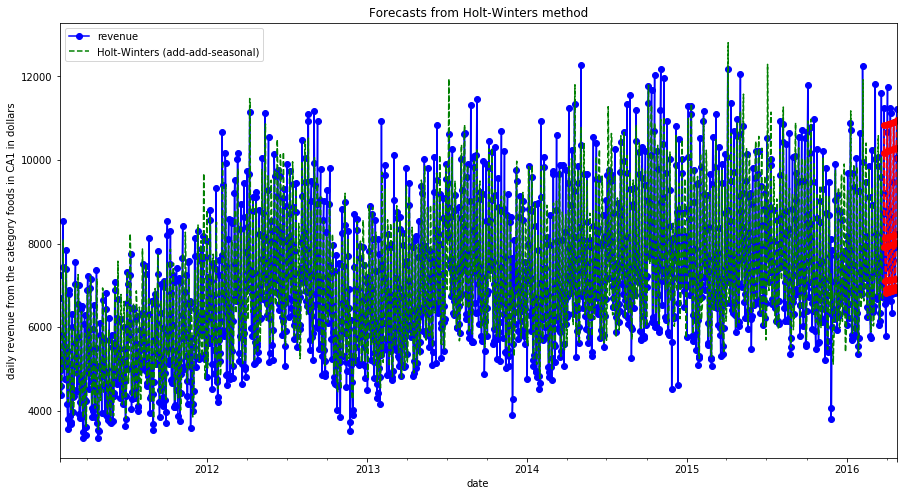

Figure 7.6: Forecasting international visitor nights in Australia using Holt-Winters method with both additive and multiplicative seasonality.


In [146]:
#Plotting actual revenue and model 2 fit and forecasts
ax = revenue_CA_1_FOODS_day.plot(figsize=(15,8), marker='o', color='blue', title="Forecasts from Holt-Winters method" )
ax.set_ylabel("daily revenue from the category foods in CA1 in dollars")
ax.set_xlabel("Year")
fit2.fittedvalues.plot(ax=ax, style='--', color='green')

fc2.rename('Holt-Winters (add-add-seasonal)').plot(ax=ax, style='--', marker='o', color='red', legend=True)

plt.show()
print("Figure 7.6: Forecasting international visitor nights in Australia using Holt-Winters method with both additive and multiplicative seasonality.")


In [148]:
#getting all the states from model 2 into a table
df = pd.DataFrame(np.c_[revenue_CA_1_FOODS_day_to_train, fit2.level, fit2.slope, fit1.season, fit2.fittedvalues],
                  columns=[r'$y_t$',r'$l_t$',r'$b_t$',r'$s_t$',r'$\hat{y}_t$'],index=revenue_CA_1_FOODS_day_to_train.index)
df.append(fc2.rename(r'$\hat{y}_t$').to_frame(), sort=True)

,$\hat{y}_t$,$b_t$,$l_t$,$s_t$,$y_t$
2011-01-29,6750.501543,65.250774,9044.823679,-1612.627347,7240.65
2011-01-30,7131.444370,64.814286,8845.121688,-1621.515803,6705.51
2011-01-31,5181.836586,63.990830,8410.089326,-3526.866419,4584.85
2011-02-01,4408.263859,64.850077,8995.652346,-3928.272053,4965.46
2011-02-02,4584.292103,64.507258,8852.407528,-4116.549694,4368.07
...,...,...,...,...,...
2016-04-20,6961.977634,NaN,NaN,NaN,NaN
2016-04-21,6877.092918,NaN,NaN,NaN,NaN
2016-04-22,8005.594623,NaN,NaN,NaN,NaN
2016-04-23,10288.681003,NaN,NaN,NaN,NaN


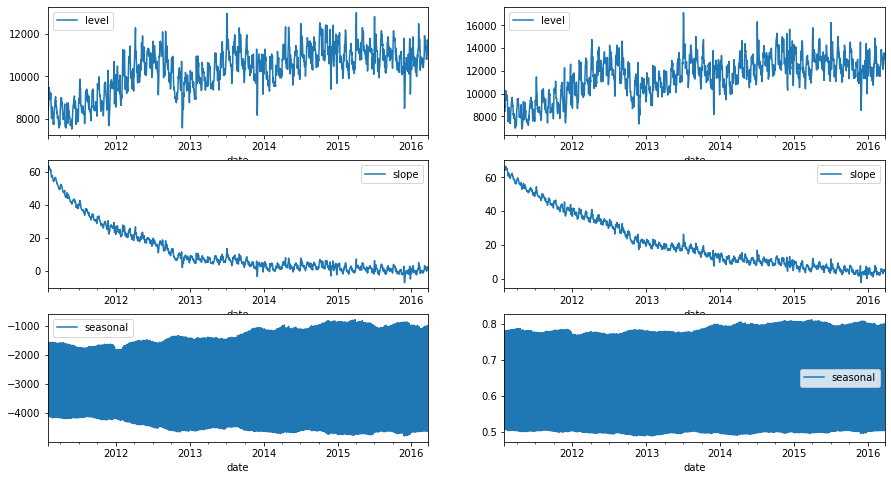

In [149]:
#Plotting the states for models 1 and 2
states1 = pd.DataFrame(np.c_[fit1.level, fit1.slope, fit1.season], columns=['level','slope','seasonal'], index=revenue_CA_1_FOODS_day_to_train.index)
states2 = pd.DataFrame(np.c_[fit2.level, fit2.slope, fit2.season], columns=['level','slope','seasonal'], index=revenue_CA_1_FOODS_day_to_train.index)
fig, [[ax1, ax4],[ax2, ax5], [ax3, ax6]] = plt.subplots(3, 2, figsize=(15,8))
states1[['level']].plot(ax=ax1)
states1[['slope']].plot(ax=ax2)
states1[['seasonal']].plot(ax=ax3)
states2[['level']].plot(ax=ax4)
states2[['slope']].plot(ax=ax5)
states2[['seasonal']].plot(ax=ax6)
plt.show()

#We can see that the exonential smoothing trend incorperates the drop in the trend 
#This stands in contrast to the ARIMA model with a fixed trend which underestimates the trend in the beginning and
#overestimates it towards the end
#seasonality is quiet strong and grows in the additive model over time which is evidence that the multiplicative model
#is better. This is confirmed by the rather constant seasonality in the additive model and its higher forecasting power

In [129]:
(rmse, mae, r2) = eval_metrics(revenue_CA_1_FOODS_day_to_test, fc1)
print(rmse,mae,r2)

766.5984704131386 605.6374920111334 0.8131094921457194
